In [186]:
import os
import itertools
import glob
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import openpyxl
import matplotlib.ticker
import matplotlib.pyplot as plt


sns.set(font_scale=1.2, style='whitegrid', font='CMU Sans Serif')

# # drawio colors
# # 189,215,238
# # 255,230,153
# pal = sns.color_palette(['#BDD7EE', '#FFE699'])
sns.set_palette("muted", 9)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (4.5,2)
mpl.rcParams['figure.dpi'] = 100

existing_dir_zh = 'zh-figures'
existing_dir_en = 'en-figures'
existing_dir_language = 'language-compare-figures'

In [187]:
def process_sheet(sheet_name):
    excel_raw_df = pd.read_excel('./result_copy.xlsx', sheet_name=sheet_name)

    name_line = excel_raw_df.head(1).dropna(axis=1, how='any')
    pass_rate_df = excel_raw_df[excel_raw_df['Index'].str.contains('PASS RATE') == True].dropna(axis=1, how='any')
    compile_rate_df = excel_raw_df[excel_raw_df['Index'].str.contains('COMPILABLE RATE') == True].dropna(axis=1, how='any')

    raw_combined_df = pd.concat([name_line, pass_rate_df, compile_rate_df], ignore_index=True)

    # Get values
    models = raw_combined_df.iloc[0, 0:6].values
    pass_rate = raw_combined_df.iloc[1, 0:6].values * 100
    compilable_rate = raw_combined_df.iloc[2, 0:6].values * 100

    model_map = {
        'gpt-4o': 'GPT-4o',
        'gpt-3.5-16k': 'GPT-3.5-Turbo',
        'gpt-4o-mini': 'GPT-4o-Mini',
        'gemini': 'Gemini',
        'llama3': 'Llama-3.1',
        'copilot': 'Copilot',
    }
    mapped_models = [model_map.get(model, model) for model in models]


    # Add Task Name
    data = {
        'Model': list(mapped_models) * 2,
        'Rate': list(pass_rate) + list(compilable_rate),
        'Type': ['PASS RATE'] * len(models) + ['COMPILABLE RATE'] * len(mapped_models),
        'Task': sheet_name,
    }
    return pd.DataFrame(data)

# Sheet Names
sheet_names = ['Fixed Plans', 'Energy Saving', 'Remote Control', 'Auto Adapt']
all_dataframes = [process_sheet(sheet_name) for sheet_name in sheet_names]

# Data Frame containing all the data from the Excel
final_df = pd.concat(all_dataframes, ignore_index=True)
final_df['Language'] = 'Chinese'

# print(final_df)
final_df.to_csv('final_df.csv', index=False)

webf NOT subset; don't know how to subset; dropped


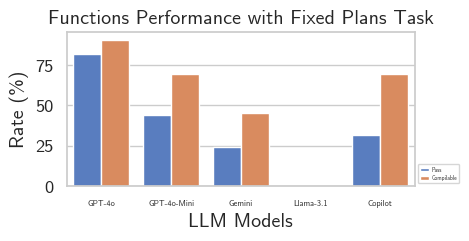

webf NOT subset; don't know how to subset; dropped


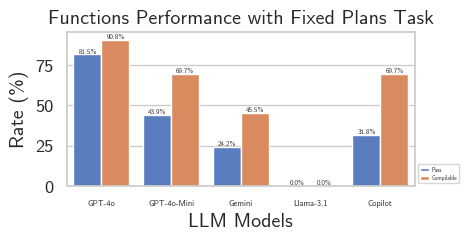

webf NOT subset; don't know how to subset; dropped


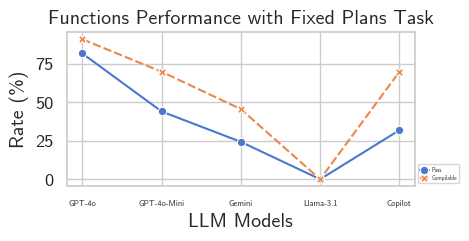

webf NOT subset; don't know how to subset; dropped


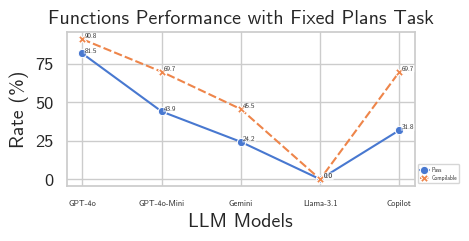

webf NOT subset; don't know how to subset; dropped


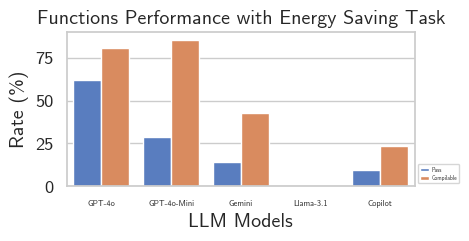

webf NOT subset; don't know how to subset; dropped


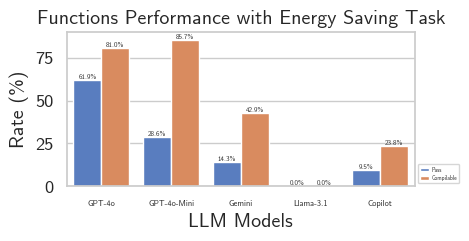

webf NOT subset; don't know how to subset; dropped


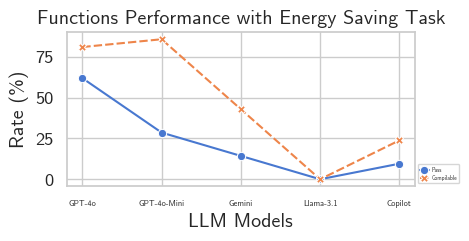

webf NOT subset; don't know how to subset; dropped


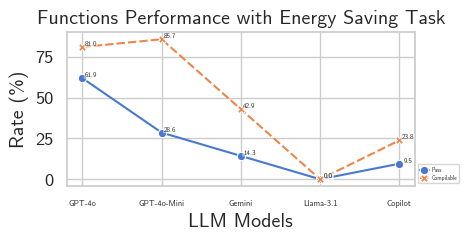

webf NOT subset; don't know how to subset; dropped


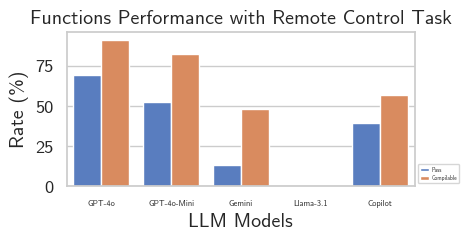

webf NOT subset; don't know how to subset; dropped


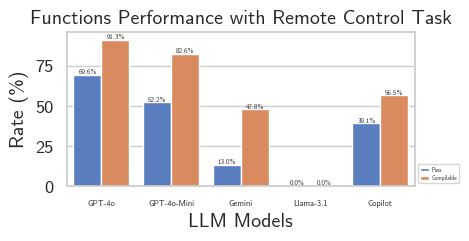

webf NOT subset; don't know how to subset; dropped


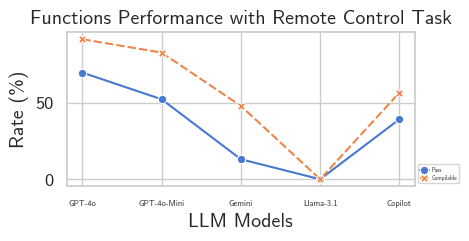

webf NOT subset; don't know how to subset; dropped


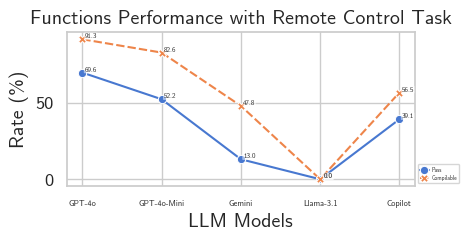

webf NOT subset; don't know how to subset; dropped


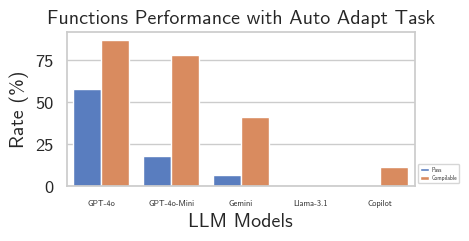

webf NOT subset; don't know how to subset; dropped


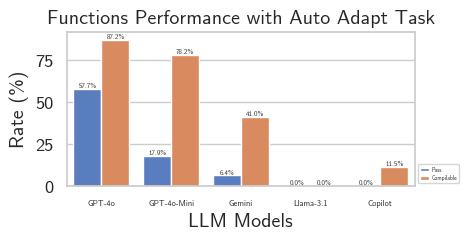

webf NOT subset; don't know how to subset; dropped


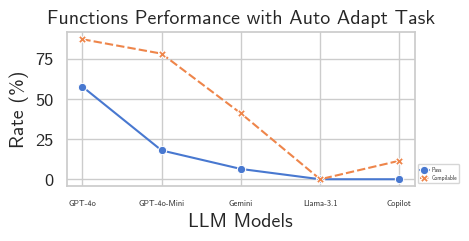

webf NOT subset; don't know how to subset; dropped


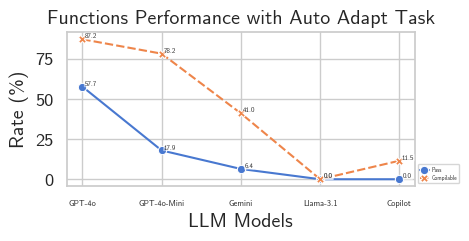

In [188]:
# barplot
def plot_bar(data, task, existing_dir, show_values=False):
    g = sns.barplot(data=data, x='Model', y='Rate', hue='Type')

    # annotation for barplot
    if show_values:
        for p in g.patches:
            height = p.get_height()
            if height != 0 or (height == 0 and isinstance(height, float)):
                g.annotate(f'{height:.1f}%',
                           (p.get_x() + p.get_width() / 2., height),
                           ha='center', va='bottom',
                           xytext=(0, 0),
                           textcoords='offset points',
                           fontsize=5)
    # legend format
    handles, labels = g.get_legend_handles_labels()
    if handles and labels:
        legend = plt.legend(
            handles=handles,
            labels=['Pass' if lbl == 'PASS RATE' else 'Compilable' for lbl in labels],
            loc='lower left',
            bbox_to_anchor=(1, 0),
            fontsize=4,
            handlelength=1.5,
            handletextpad=0.5,
            borderpad=0.4,
            borderaxespad=0.5,
            ncol=1,
            frameon=True,
        )

    # title and label
    g.set_title(f"Functions Performance with {task} Task")
    g.set_xlabel('LLM Models')
    g.set_ylabel('Rate (%)')
    plt.xticks(fontsize=6)

    # save plots
    suffix = '_with_value' if show_values else '_'
    file_path = os.path.join(existing_dir, f"{existing_dir}_{task.lower().replace(' ', '_')}_barplot{suffix}.pdf")
    plt.savefig(file_path, bbox_inches='tight')
    plt.show()

# lineplot
def plot_line(data, task, existing_dir, show_values=False):
    g = sns.lineplot(data=data, x='Model', y='Rate', hue='Type', markers=True, style='Type')

    # annotation for lineplot
    if show_values:
        for line in g.lines:
            for x, y in zip(line.get_xdata(), line.get_ydata()):
                g.annotate(f'{y:.1f}',
                           xy=(x, y),
                           xytext=(6, 0),
                           textcoords='offset points',
                           ha='center',
                           va='bottom',
                           fontsize=5,
                           bbox=dict(facecolor='white', edgecolor='none', alpha=0.5, boxstyle='round,pad=0.1'))

    # legend format
    handles, labels = g.get_legend_handles_labels()
    if handles and labels:
        legend = plt.legend(
            handles=handles,
            labels=['Pass' if lbl == 'PASS RATE' else 'Compilable' for lbl in labels],
            loc='lower left',
            bbox_to_anchor=(1, 0),
            fontsize=4,
            handlelength=1.5,
            handletextpad=0.5,
            borderpad=0.4,
            borderaxespad=0.5,
            ncol=1,
            frameon=True,
        )

    # title and label
    g.set_title(f"Functions Performance with {task} Task")
    g.set_xlabel('LLM Models')
    g.set_ylabel('Rate (%)')
    plt.xticks(fontsize=6)

    # save plots
    suffix = '_with_value' if show_values else '_'
    file_path = os.path.join(existing_dir, f"{existing_dir}_{task.lower().replace(' ', '_')}_lineplot{suffix}.pdf")
    plt.savefig(file_path, bbox_inches='tight')
    plt.show()


# task data
tasks = final_df['Task'].unique()

for task in tasks:

    task_df = final_df[final_df['Task'] == task]
    task_df = task_df[~task_df['Model'].str.contains('GPT-3.5', case=False, na=False)]

    plot_bar(task_df, task, existing_dir_zh, show_values=False)
    plot_bar(task_df, task, existing_dir_zh, show_values=True)
    plot_line(task_df, task, existing_dir_zh, show_values=False)
    plot_line(task_df, task, existing_dir_zh, show_values=True)

webf NOT subset; don't know how to subset; dropped


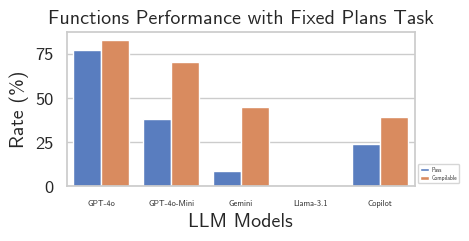

webf NOT subset; don't know how to subset; dropped


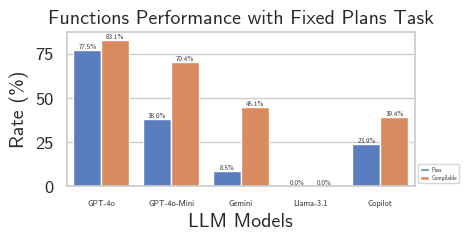

webf NOT subset; don't know how to subset; dropped


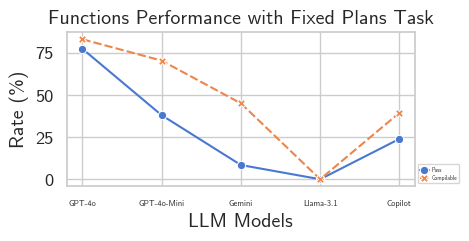

webf NOT subset; don't know how to subset; dropped


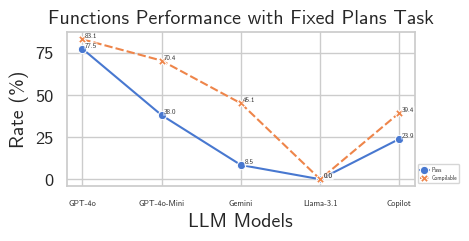

webf NOT subset; don't know how to subset; dropped


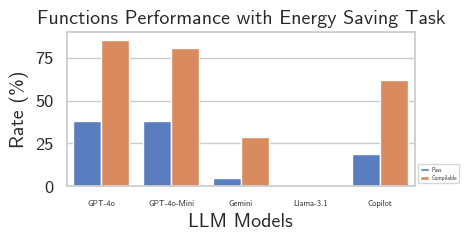

webf NOT subset; don't know how to subset; dropped


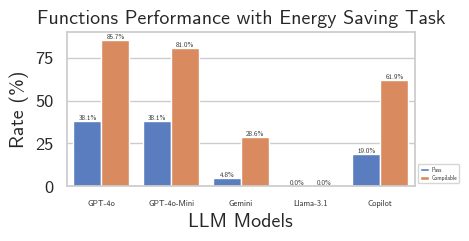

webf NOT subset; don't know how to subset; dropped


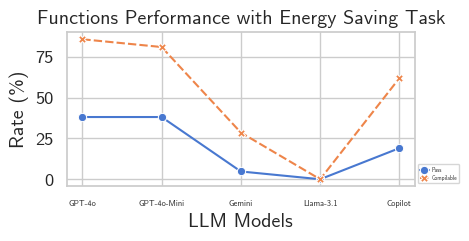

webf NOT subset; don't know how to subset; dropped


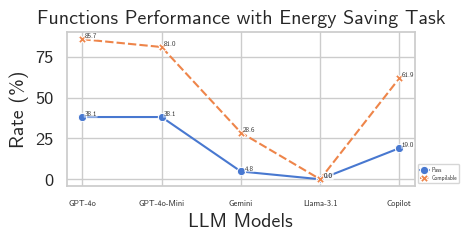

webf NOT subset; don't know how to subset; dropped


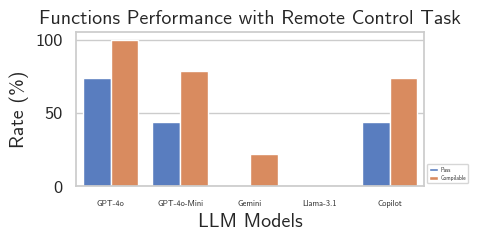

webf NOT subset; don't know how to subset; dropped


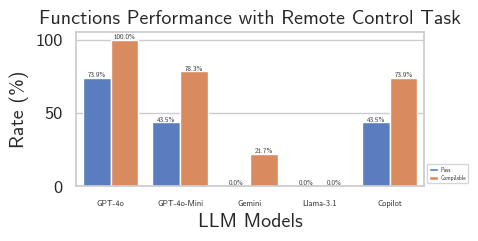

webf NOT subset; don't know how to subset; dropped


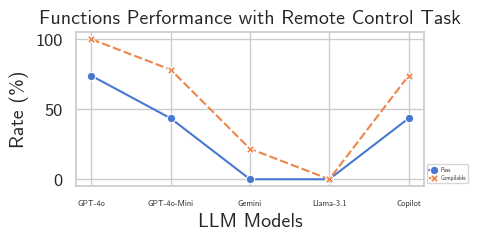

webf NOT subset; don't know how to subset; dropped


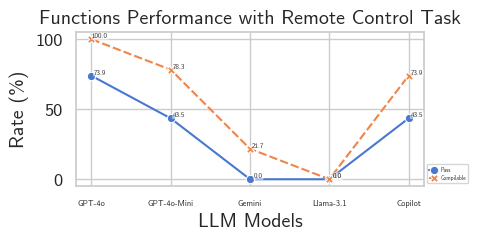

webf NOT subset; don't know how to subset; dropped


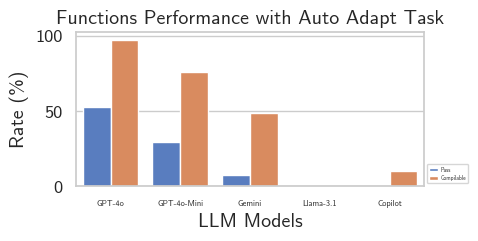

webf NOT subset; don't know how to subset; dropped


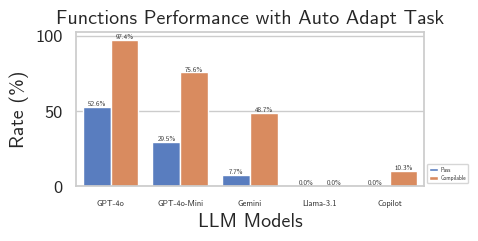

webf NOT subset; don't know how to subset; dropped


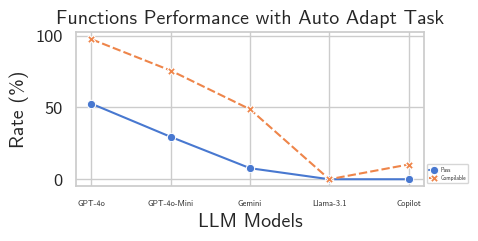

webf NOT subset; don't know how to subset; dropped


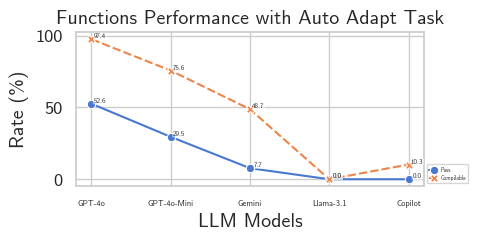

In [189]:
final_en_df = pd.read_csv('final_df_en.csv')

tasks = final_en_df['Task'].unique()

for task in tasks:
    task_df_en = final_en_df[final_en_df['Task'] == task]

    plot_bar(task_df_en, task, existing_dir_en, show_values=False)
    plot_bar(task_df_en, task, existing_dir_en, show_values=True)
    plot_line(task_df_en, task, existing_dir_en, show_values=False)
    plot_line(task_df_en, task, existing_dir_en, show_values=True)

webf NOT subset; don't know how to subset; dropped


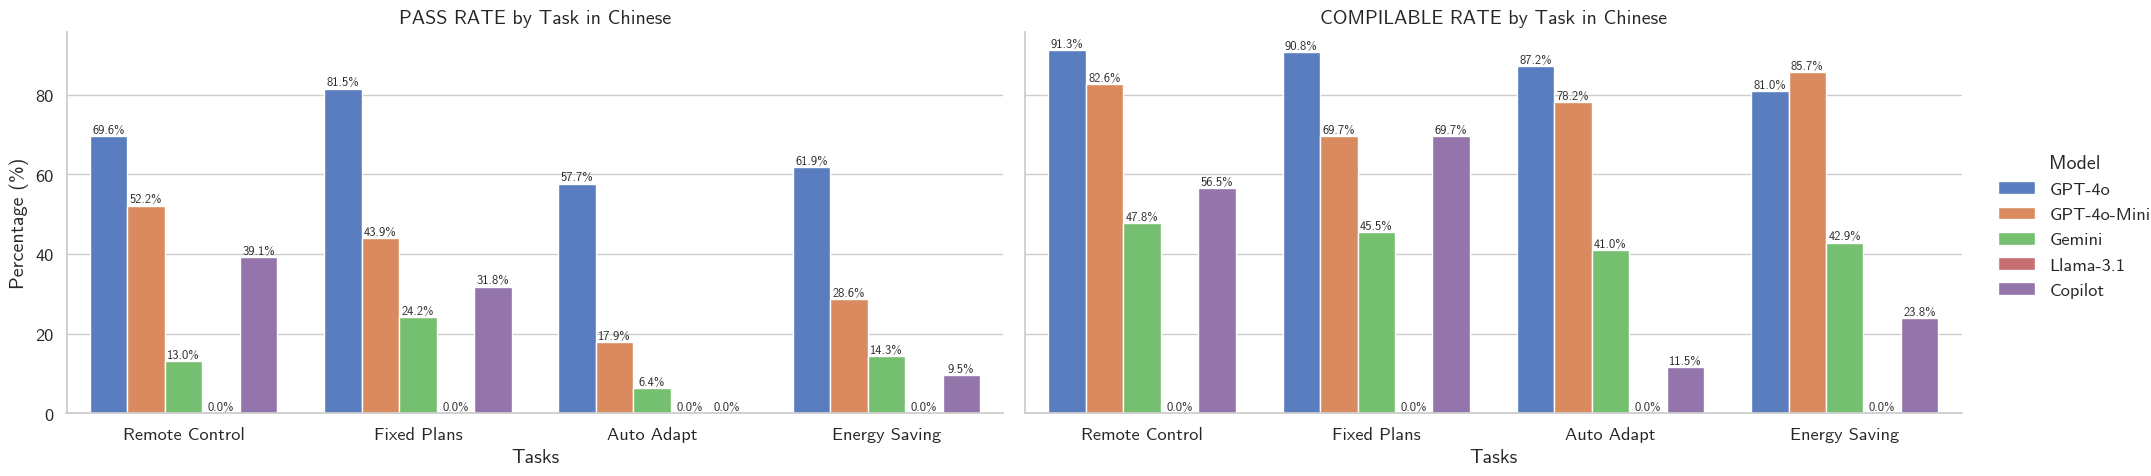

webf NOT subset; don't know how to subset; dropped


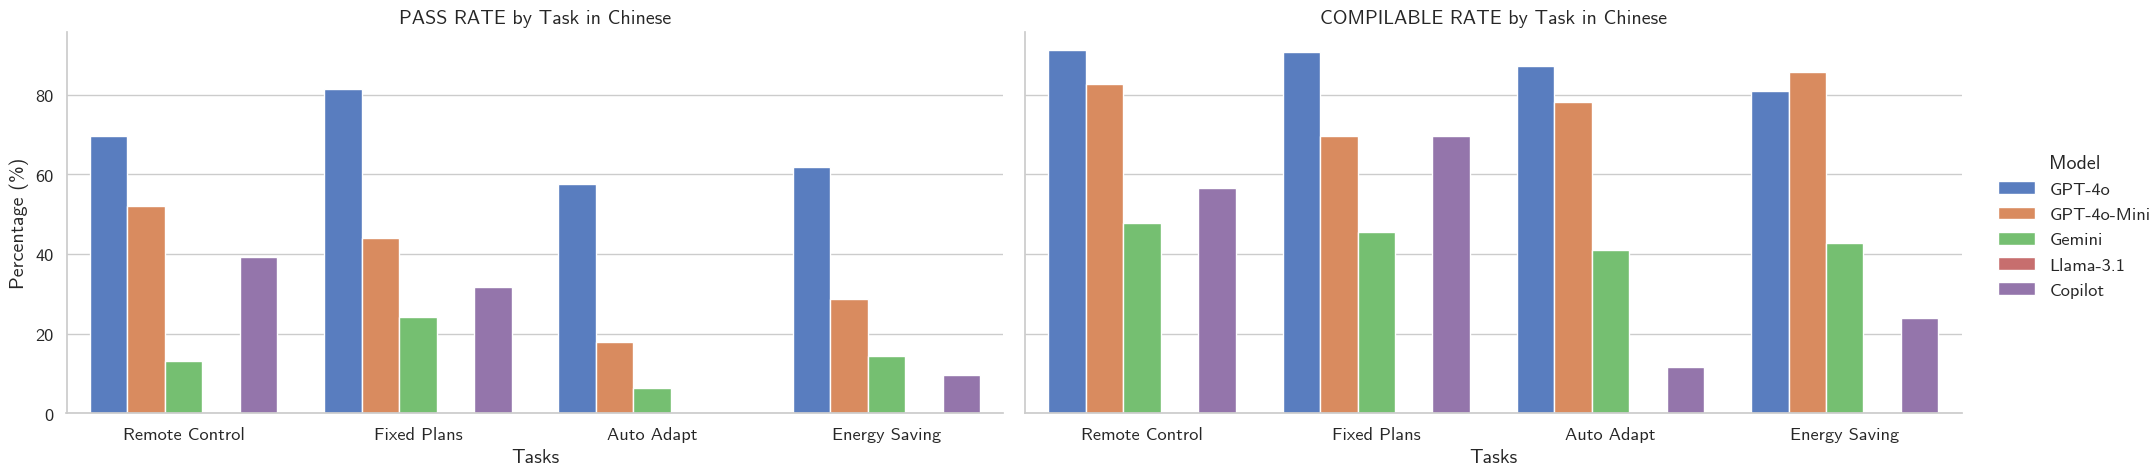

webf NOT subset; don't know how to subset; dropped


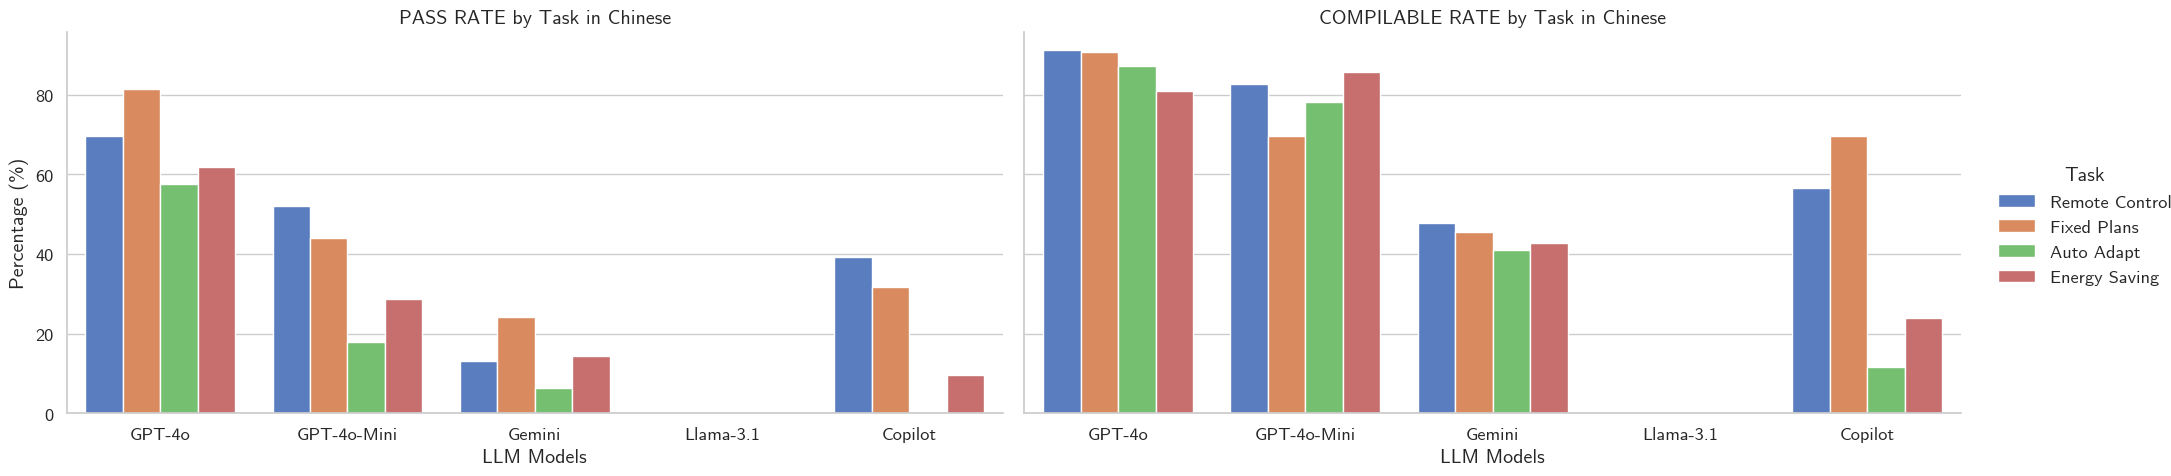

webf NOT subset; don't know how to subset; dropped


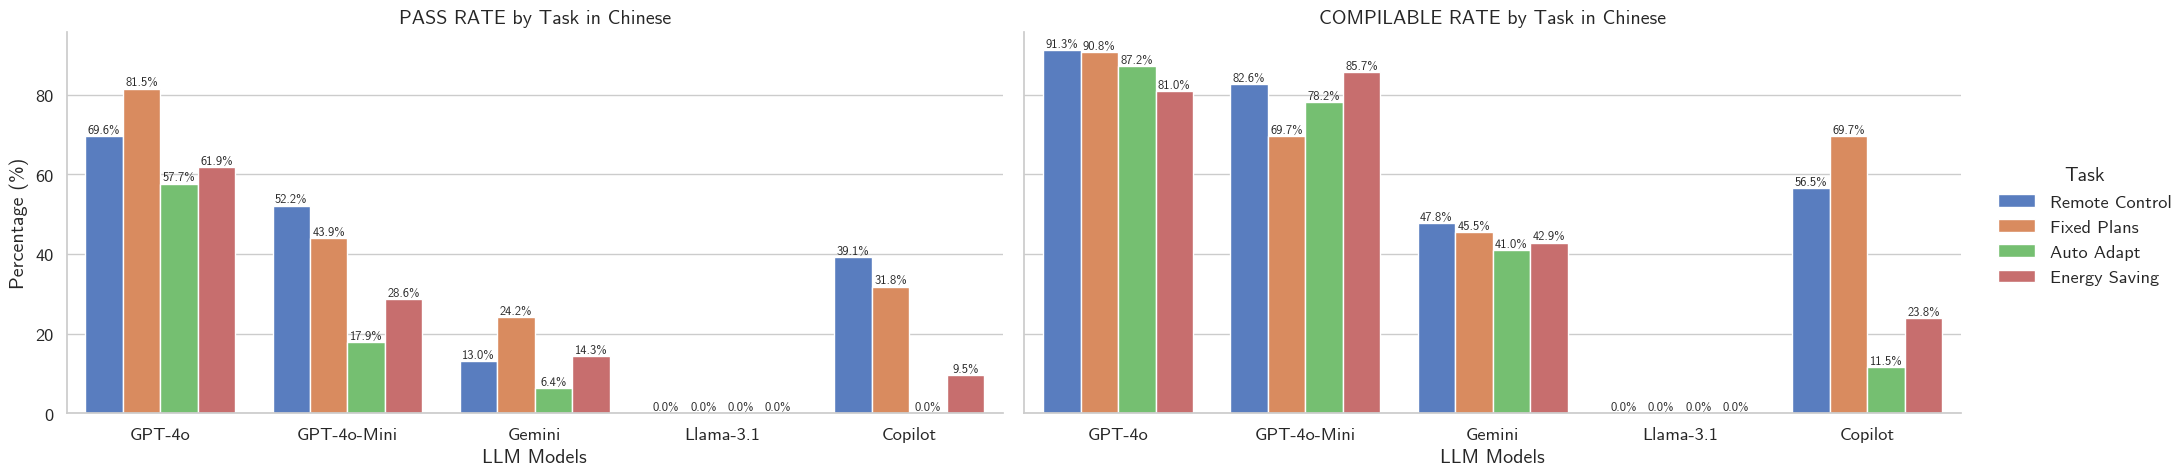

In [190]:
task_order = ["Remote Control", 'Fixed Plans', "Auto Adapt", "Energy Saving"]

final_df = final_df[~final_df['Model'].str.contains('GPT-3.5', case=False, na=False)]
final_df['Task'] = pd.Categorical(final_df['Task'], categories=task_order, ordered=True)
# print(final_df['Task'])

def plot_cat(data, x_label, hue, col, existing_dir, show_values=False):
    g = sns.catplot(
        data=data,
        x=x_label,
        y='Rate',
        hue=hue,
        col=col,
        kind='bar',
        height=5,
        aspect=2
    )

    if existing_dir.__contains__('en'):
        g.set_titles("{col_name} by Task in English")
    elif existing_dir.__contains__('zh'):
        g.set_titles("{col_name} by Task in Chinese")
    elif hue == 'Language':
        g.set_titles("Average {col_name}")
    else:
        # todo:
        g.set_titles("Task in {col_name}")

    if x_label == 'Model':
        g.set_axis_labels('LLM Models', "Percentage (%)")
    elif x_label == 'Task':
        g.set_axis_labels('Tasks', "Percentage (%)")
    else:
        g.set_axis_labels(x_label, "Percentage (%)")


    g._legend.set_bbox_to_anchor((1, 0.5))

    if show_values:
        # comment this for loop if you don't want to annotate the bars
        for ax in g.axes.flat:
            for p in ax.patches:
                height = p.get_height()

                # Only annotate if the height is not exactly 0 (but allow 0.0)
                if height != 0 or (height == 0 and isinstance(height, float)):
                    ax.annotate(f'{height:.1f}%',
                                (p.get_x() + p.get_width() / 2., height),
                                ha='center', va='bottom',
                                xytext=(0, 0),
                                textcoords='offset points',
                                fontsize=9,)
        file_path = os.path.join(existing_dir, f"{existing_dir}_all_{x_label.lower()}_{hue.lower()}_catplot_with_values.pdf")

    else:
        file_path = os.path.join(existing_dir, f"{existing_dir}_all_{x_label.lower()}_{hue.lower()}_catplot.pdf")


    plt.savefig(file_path, bbox_inches='tight')
    plt.show()


plot_cat(final_df, 'Task', 'Model', 'Type', existing_dir_zh, True)
plot_cat(final_df, 'Task', 'Model', 'Type', existing_dir_zh, False)

plot_cat(final_df, 'Model', 'Task', 'Type', existing_dir_zh, False)
plot_cat(final_df, 'Model', 'Task', 'Type', existing_dir_zh, True)

webf NOT subset; don't know how to subset; dropped


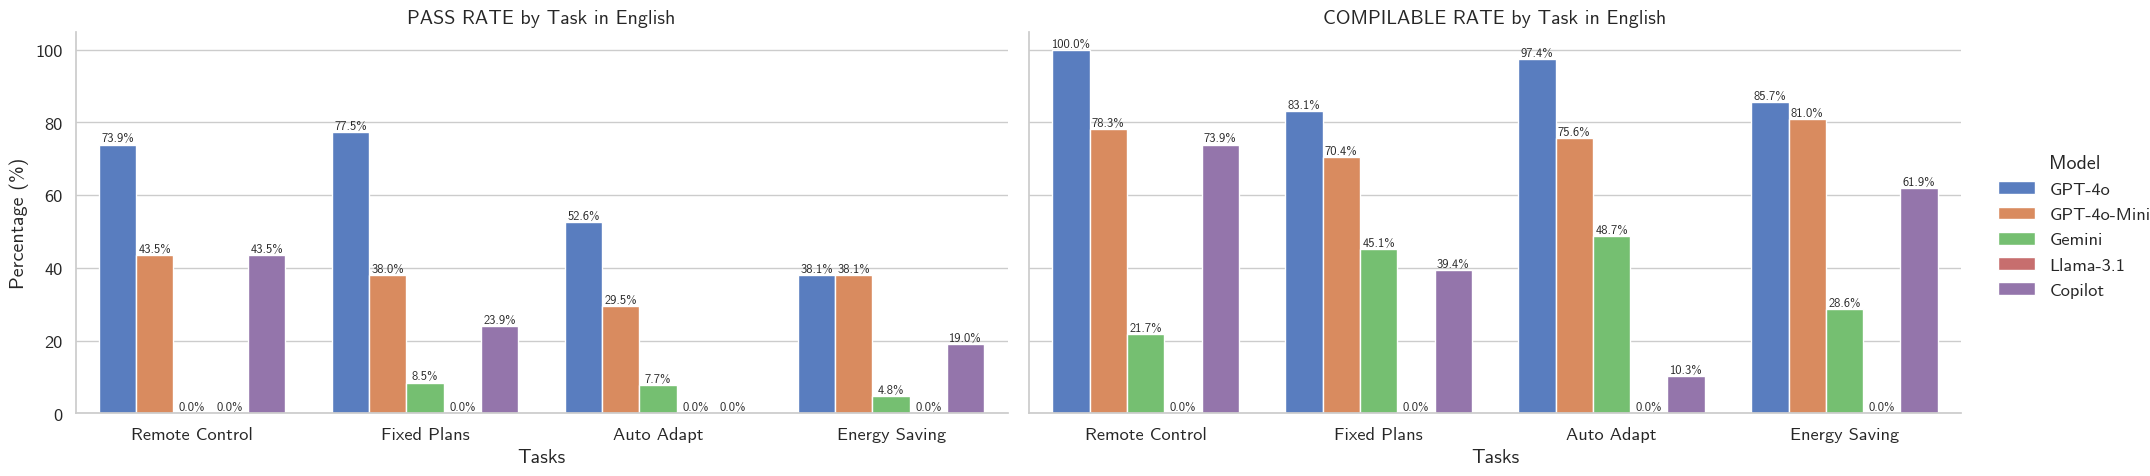

webf NOT subset; don't know how to subset; dropped


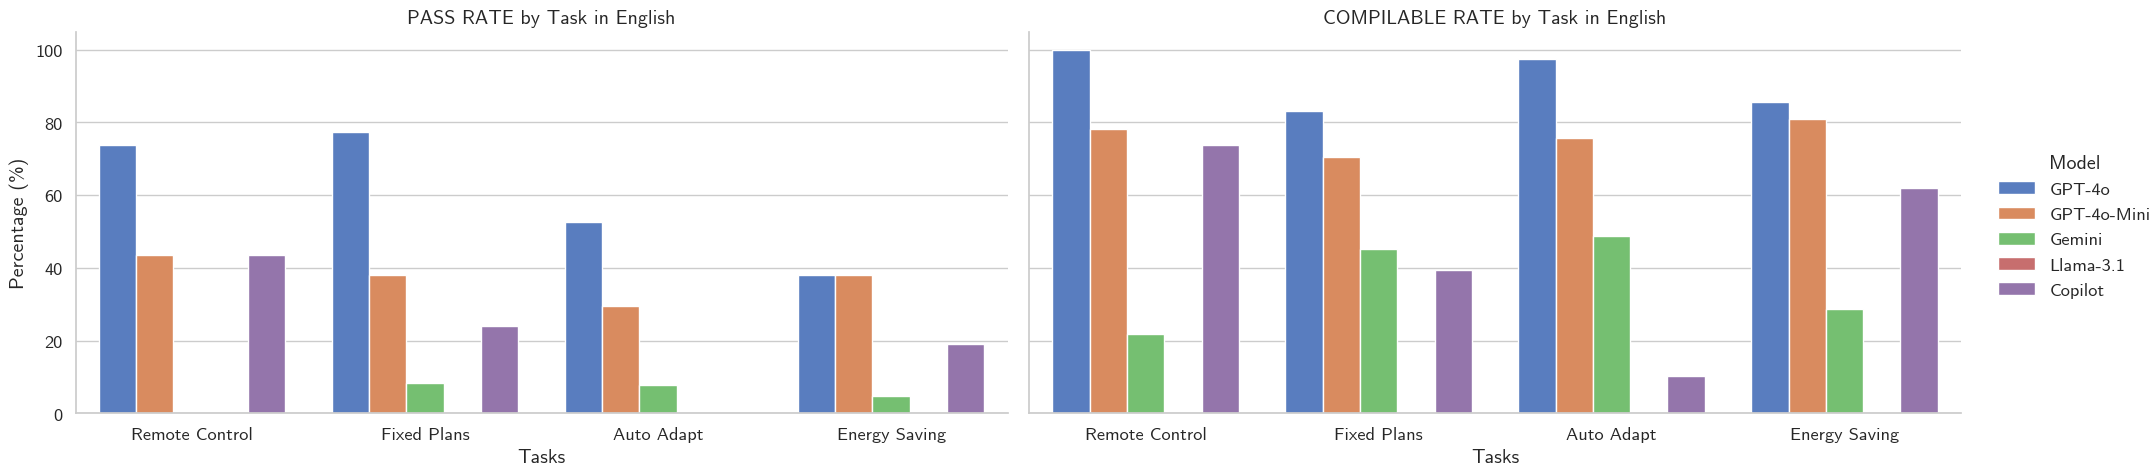

webf NOT subset; don't know how to subset; dropped


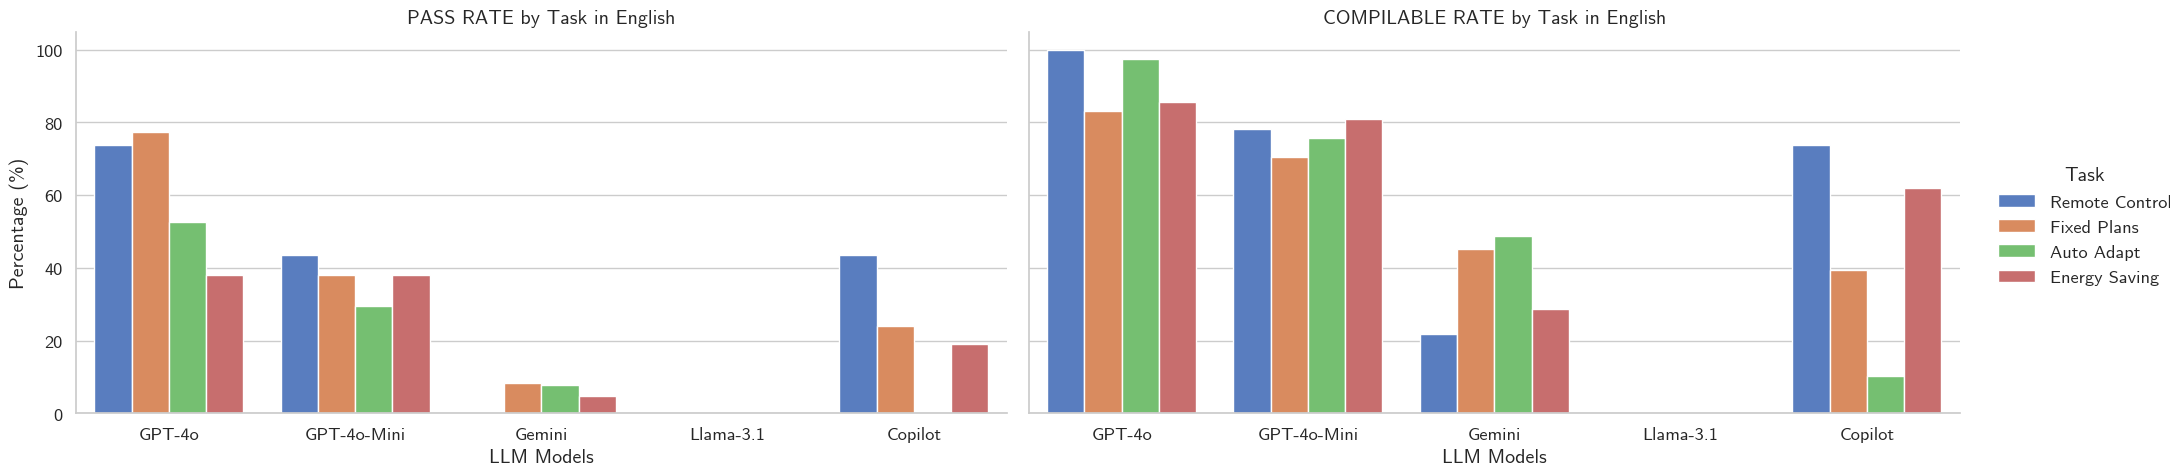

webf NOT subset; don't know how to subset; dropped


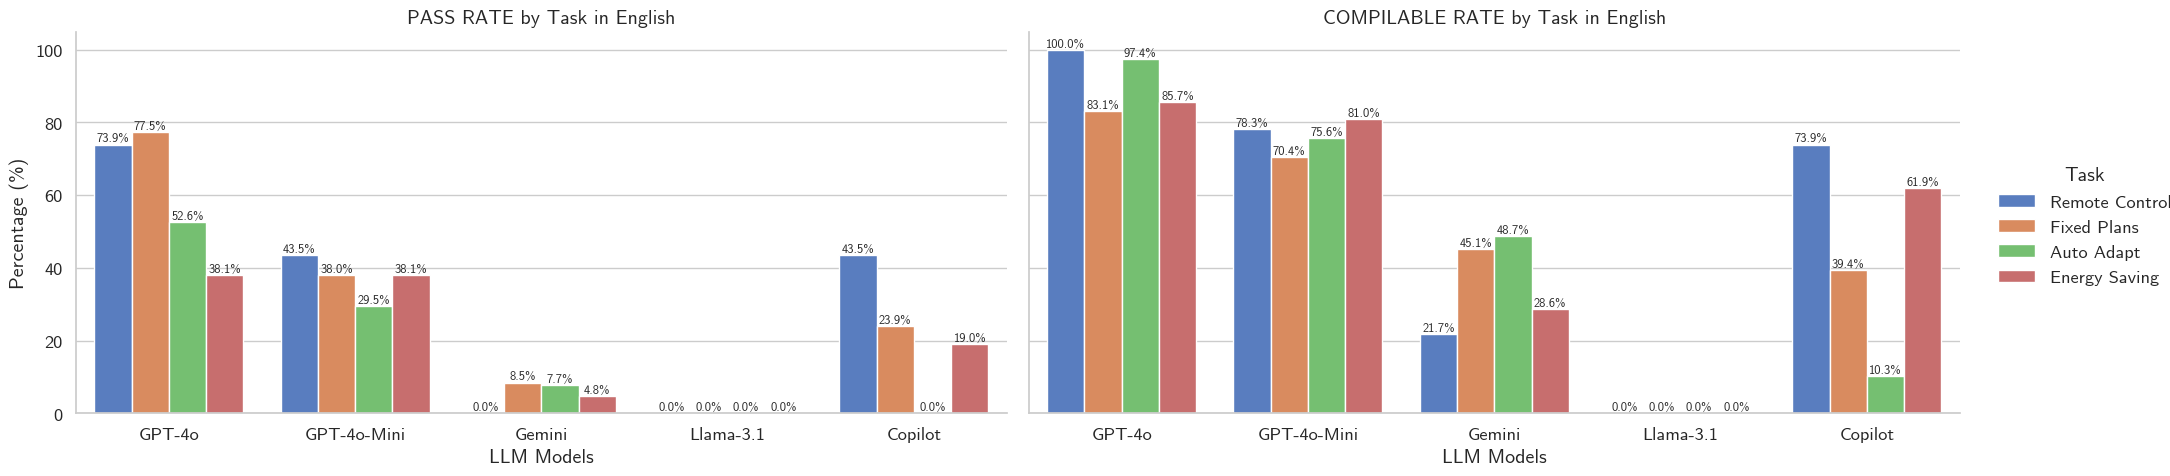

In [191]:
task_order = ["Remote Control", 'Fixed Plans', "Auto Adapt", "Energy Saving"]
final_en_df['Task'] = pd.Categorical(final_en_df['Task'], categories=task_order, ordered=True)

plot_cat(final_en_df, 'Task', 'Model', 'Type', existing_dir_en, True)
plot_cat(final_en_df, 'Task', 'Model', 'Type', existing_dir_en, False)

plot_cat(final_en_df, 'Model', 'Task', 'Type', existing_dir_en, False)
plot_cat(final_en_df, 'Model', 'Task', 'Type', existing_dir_en, True)

webf NOT subset; don't know how to subset; dropped


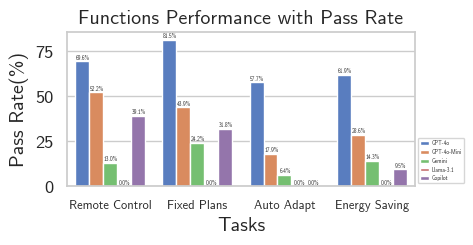

webf NOT subset; don't know how to subset; dropped


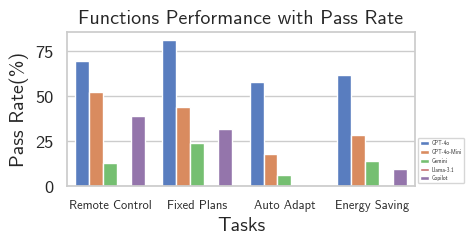

webf NOT subset; don't know how to subset; dropped


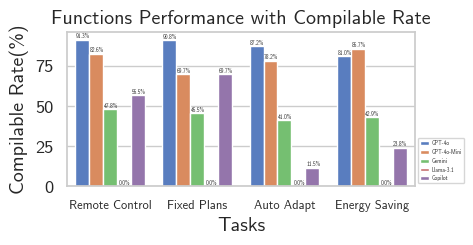

webf NOT subset; don't know how to subset; dropped


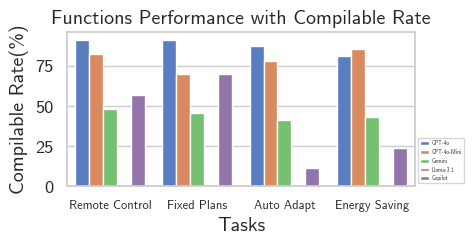

In [192]:
def bar_plot_task_model(data, rate, x_label, hue, existing_dir, show_values=False):
    plot_data = data[data['Type'] == rate]
    g = sns.barplot(data=plot_data, x=x_label, y='Rate', hue=hue)

    handles, labels = g.get_legend_handles_labels()

    if handles and labels:
        legend = plt.legend(
            handles=handles,
            labels=labels,
            loc='lower left',
            bbox_to_anchor=(1,0),
            fontsize=4,          # Adjust font size
            handlelength=1.5,          # Adjust length of legend handles
            handletextpad=0.5,         # Space between handle and text
            borderpad=0.4,             # Padding between legend border and content
            borderaxespad=0.5,         # Padding between legend border and axes
            title=None,      # Add a title if needed
            title_fontsize='medium',    # Font size of the title
            ncol = 1,
            frameon = True,
        )
    if rate == 'PASS RATE':
        rate = "Pass Rate"
    elif rate == 'COMPILABLE RATE':
        rate = "Compilable Rate"

    if show_values:
        # annotation for barplot
        for p in g.patches:
            height = p.get_height()
            if height != 0 or (height == 0 and isinstance(height, float)):
                g.annotate(f'{height:.1f}%',
                           (p.get_x() + p.get_width() / 2., height),
                           ha='center', va='bottom',
                           xytext=(0.5, 0.5),
                           textcoords='offset points',
                           fontsize=4)

    g.set_title(f"Functions Performance with {rate}")
    g.set_xlabel('Tasks')
    g.set_ylabel(f"{rate}(%)" )

    plt.xticks(fontsize=9)

    # save plots
    suffix = '_with_value' if show_values else '_'
    file_path = os.path.join(existing_dir, f"{existing_dir}_task_{rate.lower().replace(' ', '_')}_barplot{suffix}.pdf")
    plt.savefig(file_path, bbox_inches='tight')
    plt.show()


bar_plot_task_model(final_df, 'PASS RATE', 'Task', 'Model', existing_dir_zh, True)
bar_plot_task_model(final_df, 'PASS RATE', 'Task', 'Model', existing_dir_zh, False)

bar_plot_task_model(final_df, 'COMPILABLE RATE', 'Task', 'Model', existing_dir_zh, True)
bar_plot_task_model(final_df, 'COMPILABLE RATE', 'Task', 'Model', existing_dir_zh, False)

webf NOT subset; don't know how to subset; dropped


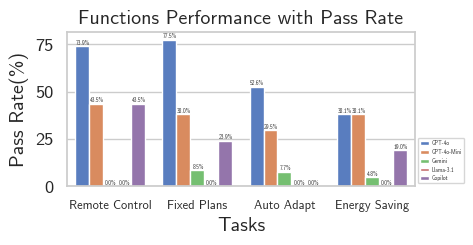

webf NOT subset; don't know how to subset; dropped


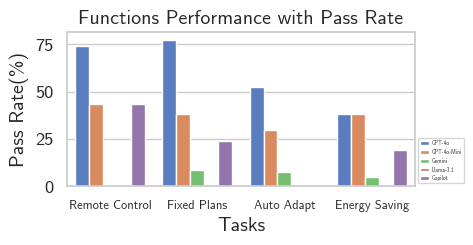

webf NOT subset; don't know how to subset; dropped


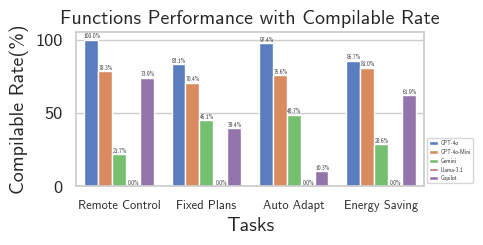

webf NOT subset; don't know how to subset; dropped


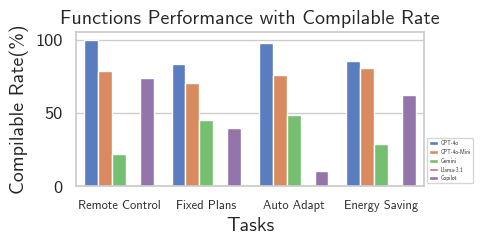

In [193]:
bar_plot_task_model(final_en_df, 'PASS RATE', 'Task', 'Model', existing_dir_en, True)
bar_plot_task_model(final_en_df, 'PASS RATE', 'Task', 'Model', existing_dir_en, False)

bar_plot_task_model(final_en_df, 'COMPILABLE RATE', 'Task', 'Model', existing_dir_en, True)
bar_plot_task_model(final_en_df, 'COMPILABLE RATE', 'Task', 'Model', existing_dir_en, False)

webf NOT subset; don't know how to subset; dropped


         Model             Type Language       Rate
0      Copilot  COMPILABLE RATE  Chinese  40.391674
1      Copilot        PASS RATE  Chinese  20.118107
2       GPT-4o  COMPILABLE RATE  Chinese  87.551362
3       GPT-4o        PASS RATE  Chinese  67.675187
4  GPT-4o-Mini  COMPILABLE RATE  Chinese  79.056270
5  GPT-4o-Mini        PASS RATE  Chinese  35.658363
6       Gemini  COMPILABLE RATE  Chinese  44.290854
7       Gemini        PASS RATE  Chinese  14.495468
8    Llama-3.1  COMPILABLE RATE  Chinese   0.000000
9    Llama-3.1        PASS RATE  Chinese   0.000000
0      Copilot  COMPILABLE RATE  English  46.377709
1      Copilot        PASS RATE  English  21.617385
2       GPT-4o  COMPILABLE RATE  English  91.562194
3       GPT-4o        PASS RATE  English  60.509293
4  GPT-4o-Mini  COMPILABLE RATE  English  76.319203
5  GPT-4o-Mini        PASS RATE  English  37.272212
6       Gemini  COMPILABLE RATE  English  36.024733
7       Gemini        PASS RATE  English   5.226229
8    Llama-3

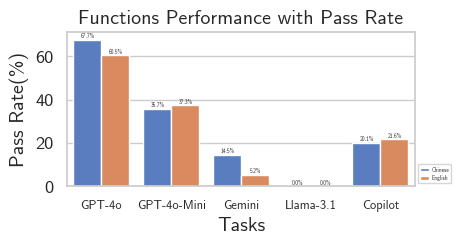

webf NOT subset; don't know how to subset; dropped


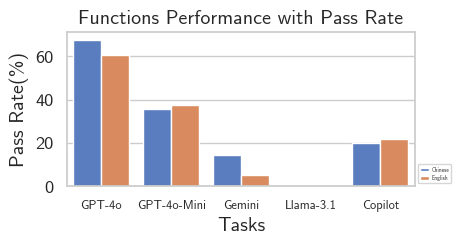

webf NOT subset; don't know how to subset; dropped


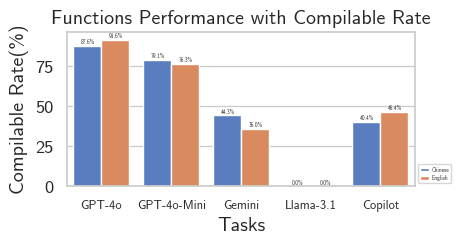

webf NOT subset; don't know how to subset; dropped


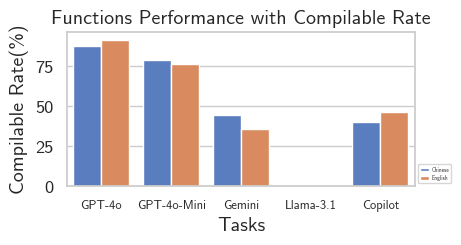

In [194]:
avg_rates_en = final_en_df.groupby(['Model', 'Type', 'Language'])['Rate'].mean().reset_index()
avg_rates_zh = final_df.groupby(['Model', 'Type', 'Language'])['Rate'].mean().reset_index()

merged_df = pd.concat([avg_rates_zh, avg_rates_en])

model_order = ['GPT-4o', 'GPT-4o-Mini', 'Gemini', 'Llama-3.1', 'Copilot']
merged_df['Model'] = pd.Categorical(merged_df['Model'], categories=model_order, ordered=True)

print(merged_df)

bar_plot_task_model(merged_df, 'PASS RATE','Model', 'Language', existing_dir_language, True)
bar_plot_task_model(merged_df, 'PASS RATE', 'Model', 'Language',existing_dir_language, False)

bar_plot_task_model(merged_df, 'COMPILABLE RATE', 'Model', 'Language',existing_dir_language, True)
bar_plot_task_model(merged_df, 'COMPILABLE RATE', 'Model', 'Language',existing_dir_language, False)

webf NOT subset; don't know how to subset; dropped


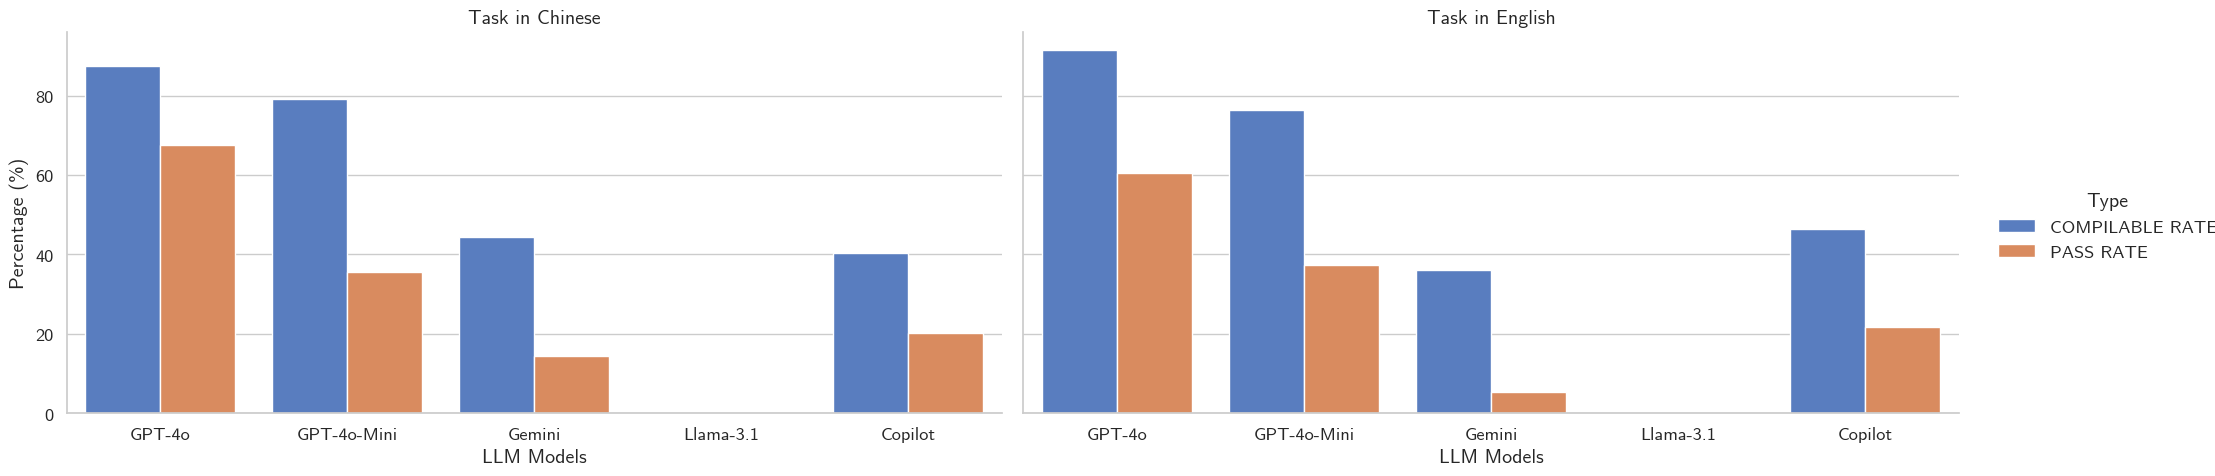

webf NOT subset; don't know how to subset; dropped


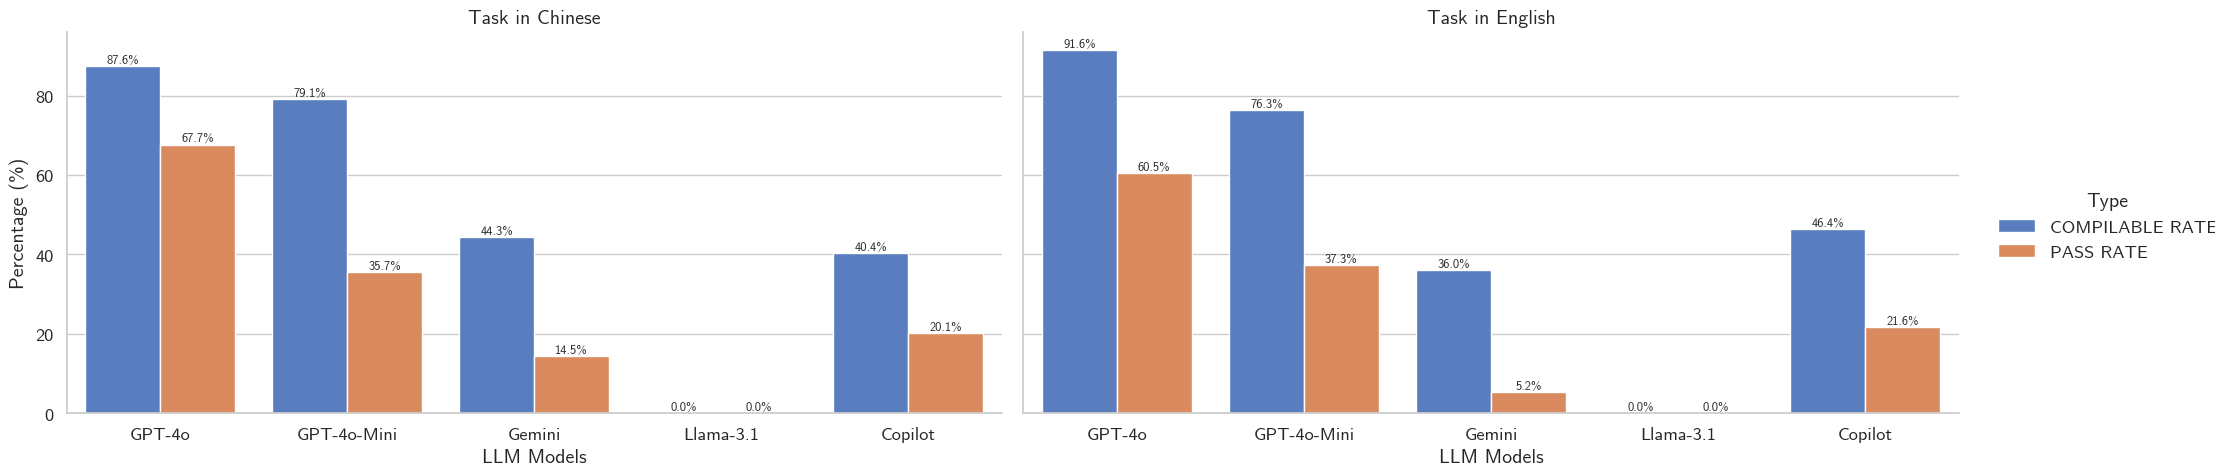

In [195]:
plot_cat(merged_df, 'Model', 'Type', 'Language', existing_dir_language, False)
plot_cat(merged_df, 'Model', 'Type', 'Language', existing_dir_language, True)

webf NOT subset; don't know how to subset; dropped


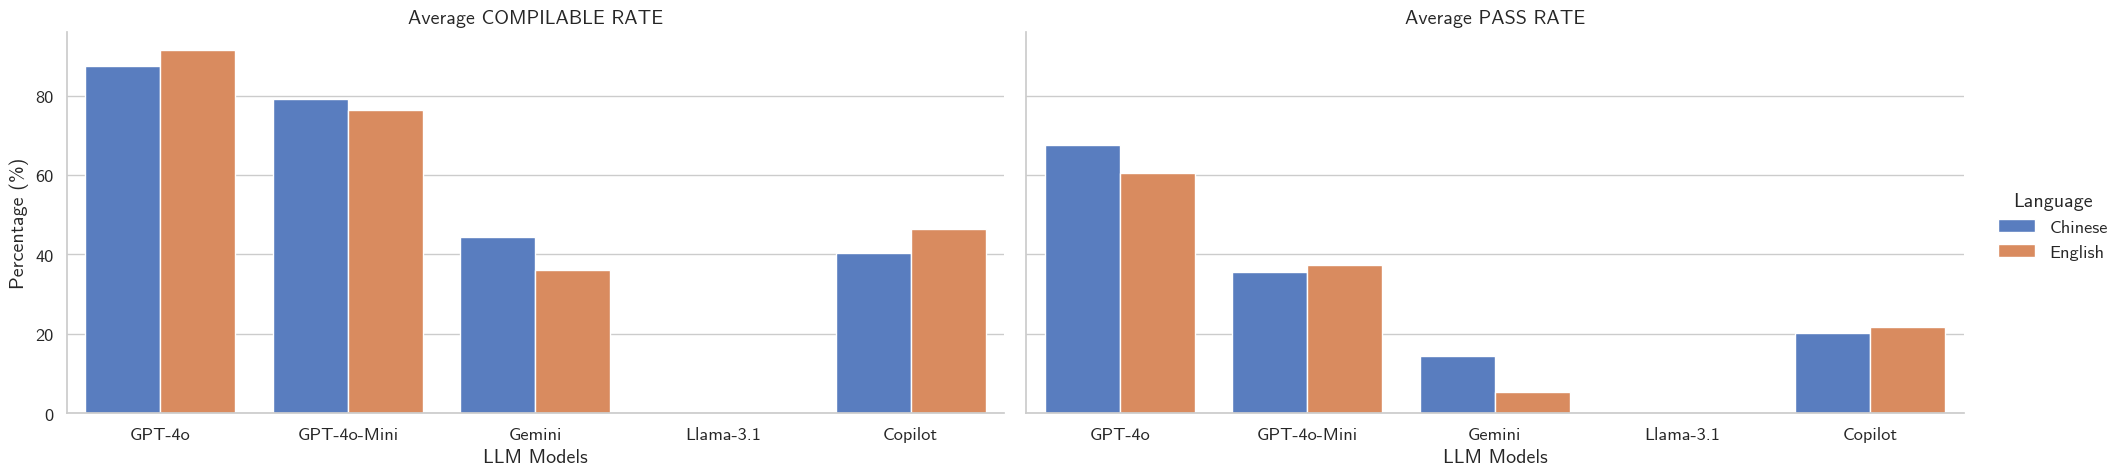

webf NOT subset; don't know how to subset; dropped


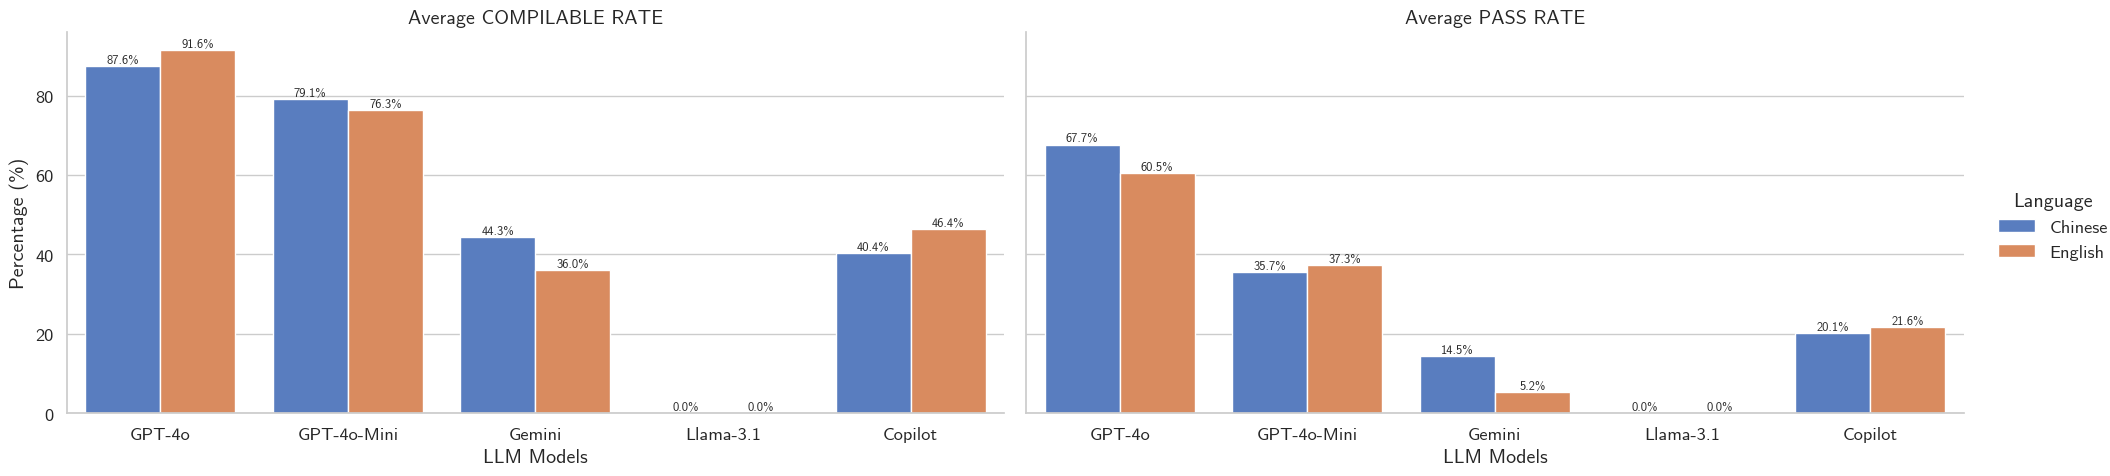

In [196]:
plot_cat(merged_df, 'Model', 'Language', 'Type', existing_dir_language, False)
plot_cat(merged_df, 'Model', 'Language', 'Type', existing_dir_language, True)